In [1]:
import random
import re
import matplotlib.pyplot as plt 
import networkx as nx
    
# Load graph from GML file
def load_graph(gml_file):
    with open(gml_file, 'r') as file:
        data = file.read()
        
    nodes = re.findall(r'node\s+\[\s+id\s+(\d+)', data)
    edges = re.findall(r'edge\s+\[\s+source\s+(\d+)\s+target\s+(\d+)', data)
    
    graph = {int(node): [] for node in nodes}
    for source, target in edges:
        graph[int(source)].append(int(target))
        graph[int(target)].append(int(source))
        
    return graph

# Initialize population
def initialize_population(graph, population_size):
    population = []
    for _ in range(population_size):
        individual = {node: random.randint(0, len(graph) - 1) for node in graph}
        population.append(individual)
    return population

# Fitness function (Modularity)
def fitness(graph, individual):
    m = sum(len(neighbors) for neighbors in graph.values()) / 2
    Q = 0.0
    for community in set(individual.values()):
        nodes_in_community = [node for node, comm in individual.items() if comm == community]
        l_c = sum(len([neighbor for neighbor in graph[node] if individual[neighbor] == community]) for node in nodes_in_community) / 2
        d_c = sum(len(graph[node]) for node in nodes_in_community)
        Q += (l_c / m) - (d_c / (2 * m)) ** 2
    return Q

# Selection: Tournament selection
def tournament_selection(population, fitnesses, k=3):
    selected = random.sample(list(range(len(population))), k)
    selected = sorted(selected, key=lambda x: fitnesses[x], reverse=True)
    return population[selected[0]]

# Crossover: Single-point crossover
def crossover(parent1, parent2):
    nodes = list(parent1.keys())
    crossover_point = random.randint(0, len(nodes) - 1)
    child1 = {}
    child2 = {}
    for i, node in enumerate(nodes):
        if i < crossover_point:
            child1[node] = parent1[node]
            child2[node] = parent2[node]
        else:
            child1[node] = parent2[node]
            child2[node] = parent1[node]
    return child1, child2

# Mutation: Node reassignment
def mutate(individual, mutation_rate=0.01):
    for node in individual:
        if random.random() < mutation_rate:
            individual[node] = random.randint(0, len(individual) - 1)
    return individual

# Replacement: Elitism
def replace_population(population, new_population, fitnesses, new_fitnesses):
    combined_population = population + new_population
    combined_fitnesses = fitnesses + new_fitnesses
    sorted_indices = sorted(range(len(combined_population)), key=lambda k: combined_fitnesses[k], reverse=True)
    return [combined_population[i] for i in sorted_indices[:len(population)]], [combined_fitnesses[i] for i in sorted_indices[:len(population)]]

# Evolutionary Algorithm
def evolutionary_algorithm(graph, population_size=100, generations=500, mutation_rate=0.01):
    population = initialize_population(graph, population_size)
    fitnesses = [fitness(graph, individual) for individual in population]
    
    for generation in range(generations):
        new_population = []
        new_fitnesses = []
        
        while len(new_population) < population_size:
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            
            child1, child2 = crossover(parent1, parent2)
            
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)
            
            new_population.append(child1)
            new_population.append(child2)
            new_fitnesses.append(fitness(graph, child1))
            new_fitnesses.append(fitness(graph, child2))
        
        population, fitnesses = replace_population(population, new_population, fitnesses, new_fitnesses)
        
        # Print the best fitness in the current generation
        best_fitness = max(fitnesses)
        if generation % 250 == 0:
            print(f"Generation {generation}: Best Fitness = {best_fitness}")
        
    # Return the best individual
    best_index = fitnesses.index(max(fitnesses))
    return population[best_index]

# Relabel communities to ensure continuous labels
def relabel_communities(community_structure):
    unique_communities = sorted(set(community_structure.values()))
    community_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_communities)}
    relabeled_community_structure = {node: community_mapping[comm] for node, comm in community_structure.items()}
    return relabeled_community_structure

# Print the community structure
def print_community_structure(community_structure):
    communities = {}
    for node, community in community_structure.items():
        if community not in communities:
            communities[community] = []
        communities[community].append(node)
    
    sorted_communities = sorted(communities.items())
    for community, nodes in sorted_communities:
        print(f"Community {community}: {sorted(nodes)}")

def GA(gml_file, pSize = 100, gen = 501):
    graph = load_graph(gml_file)
    best_community_structure = evolutionary_algorithm(graph, pSize, gen)
    best_community_structure = relabel_communities(best_community_structure)
    print("Best community structure:")
    print_community_structure(best_community_structure)    
    try :
        G = nx.read_gml(gml_file)
    except:
        G = nx.read_gml(gml_file, label='id')

    pos = nx.spring_layout(G)  
    plt.figure(figsize=(15, 15)) 
    plt.title("Found communities")
    nx.draw_networkx_nodes(G, pos, node_size = 600, cmap = plt.cm.RdYlBu, node_color = list(best_community_structure.values()))
    nx.draw_networkx_edges(G, pos, alpha = 0.3)
    nx.draw_networkx_labels(G, pos)
    plt.show(G)

Generation 0: Best Fitness = 0.007119971520113921
Generation 250: Best Fitness = 0.4044143823424706
Generation 500: Best Fitness = 0.4499030892765318
Best community structure:
Community 0: [0, 2, 10, 28, 30, 42, 47]
Community 1: [1, 7, 19, 26, 27, 41, 48, 54, 57]
Community 2: [20, 44]
Community 3: [17, 22, 25, 31]
Community 4: [58]
Community 5: [3, 8, 59]
Community 6: [46, 49]
Community 7: [36, 39]
Community 8: [53, 61]
Community 9: [12, 14, 16, 33, 34, 37, 38, 40, 43, 50, 52]
Community 10: [5, 6, 9, 13, 32, 56, 60]
Community 11: [4, 11, 15, 18, 21, 23, 24, 29, 35, 45, 51, 55]


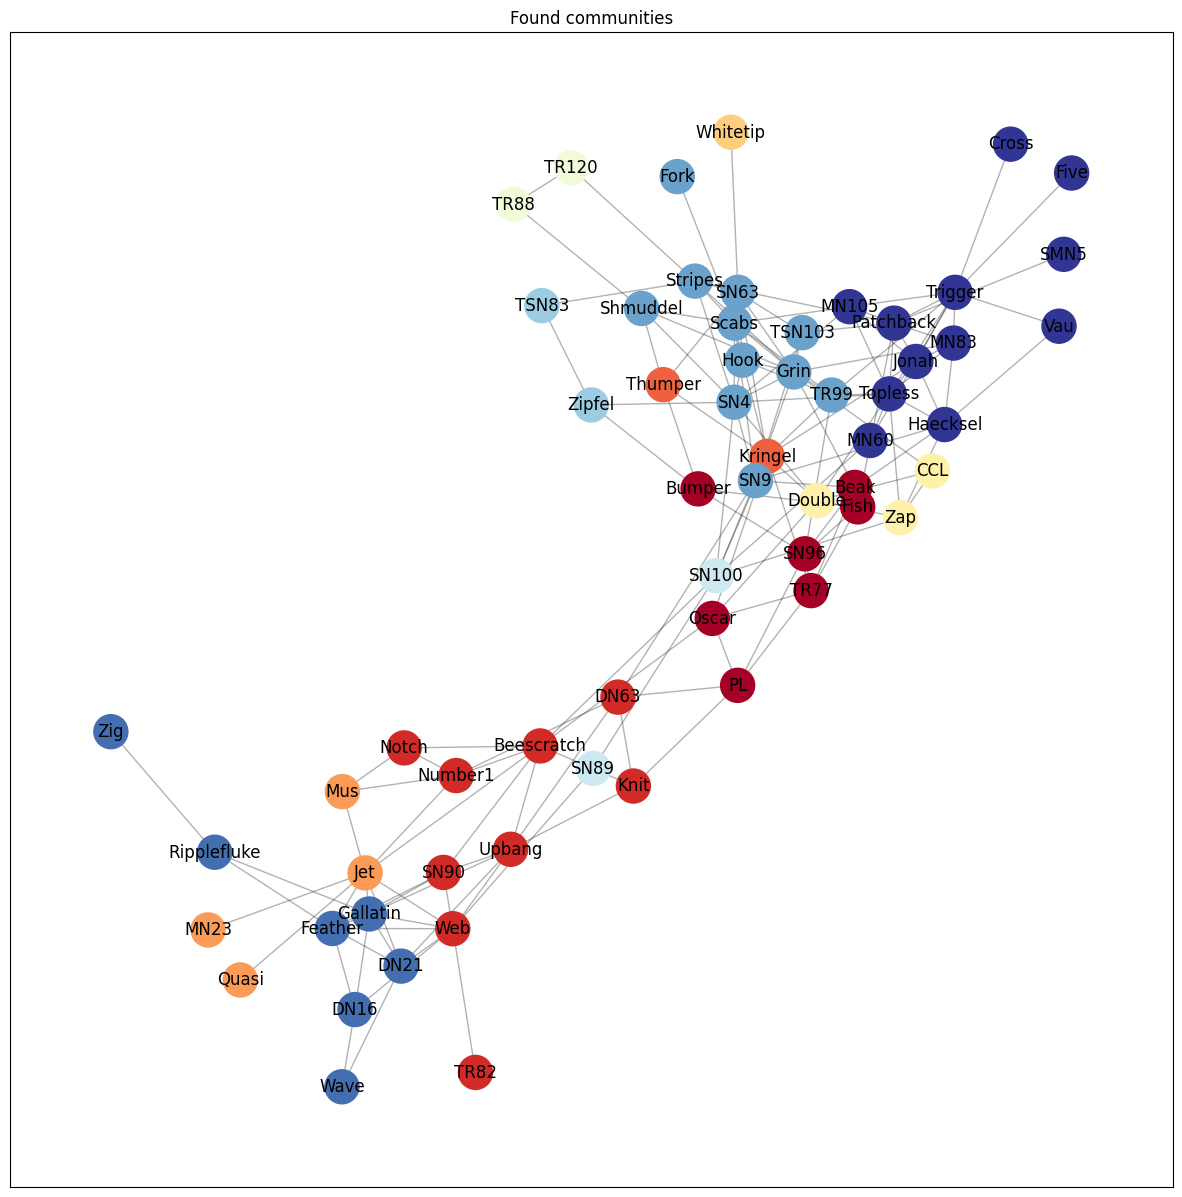

In [2]:
GA("communityDetection/data/dolphins/dolphins.gml")

In [3]:
GA("communityDetection/data/football/football.gml")

Generation 0: Best Fitness = 0.0026208572271883977
Generation 250: Best Fitness = 0.2665710912464159
Generation 500: Best Fitness = 0.4391286473266993
Best community structure:
Community 0: [3, 5, 10, 11, 40, 52, 72, 74, 81, 98, 102, 107]
Community 1: [46, 49, 53, 67, 83, 88, 114]
Community 2: [17, 20, 48, 57, 65, 75, 76, 87, 95, 96, 113]
Community 3: [7, 73, 82]
Community 4: [1, 33, 37, 45, 62, 89, 103, 105, 109]
Community 5: [47, 100]
Community 6: [58, 59, 63, 97]
Community 7: [12, 14, 26, 31, 34, 38, 42, 43, 54, 61, 71, 85, 99]
Community 8: [24, 28, 50, 69, 90]
Community 9: [80, 110]
Community 10: [27, 56, 70]
Community 11: [0, 4, 8, 9, 16, 21, 22, 23, 41, 51, 77, 78, 93, 104, 108, 111]
Community 12: [36]
Community 13: [66, 86, 91, 92, 112]
Community 14: [84]
Community 15: [68]
Community 16: [25]
Community 17: [18, 19, 29, 30, 35, 44, 55, 79, 94, 101]
Community 18: [2, 6, 13, 15, 32, 39, 60, 64, 106]


NetworkXError: edge #51 (27--17) is duplicated

Generation 0: Best Fitness = 0.01824457593688363
Generation 250: Best Fitness = 0.39981919789612097
Generation 500: Best Fitness = 0.39981919789612097
Best community structure:
Community 0: [1, 2, 3, 4, 8, 12, 13, 14, 18, 20, 22]
Community 1: [9, 10, 15, 16, 19, 21, 23, 31, 33, 34]
Community 2: [25, 26, 29, 32]
Community 3: [24, 27, 28, 30]
Community 4: [5, 6, 7, 11, 17]


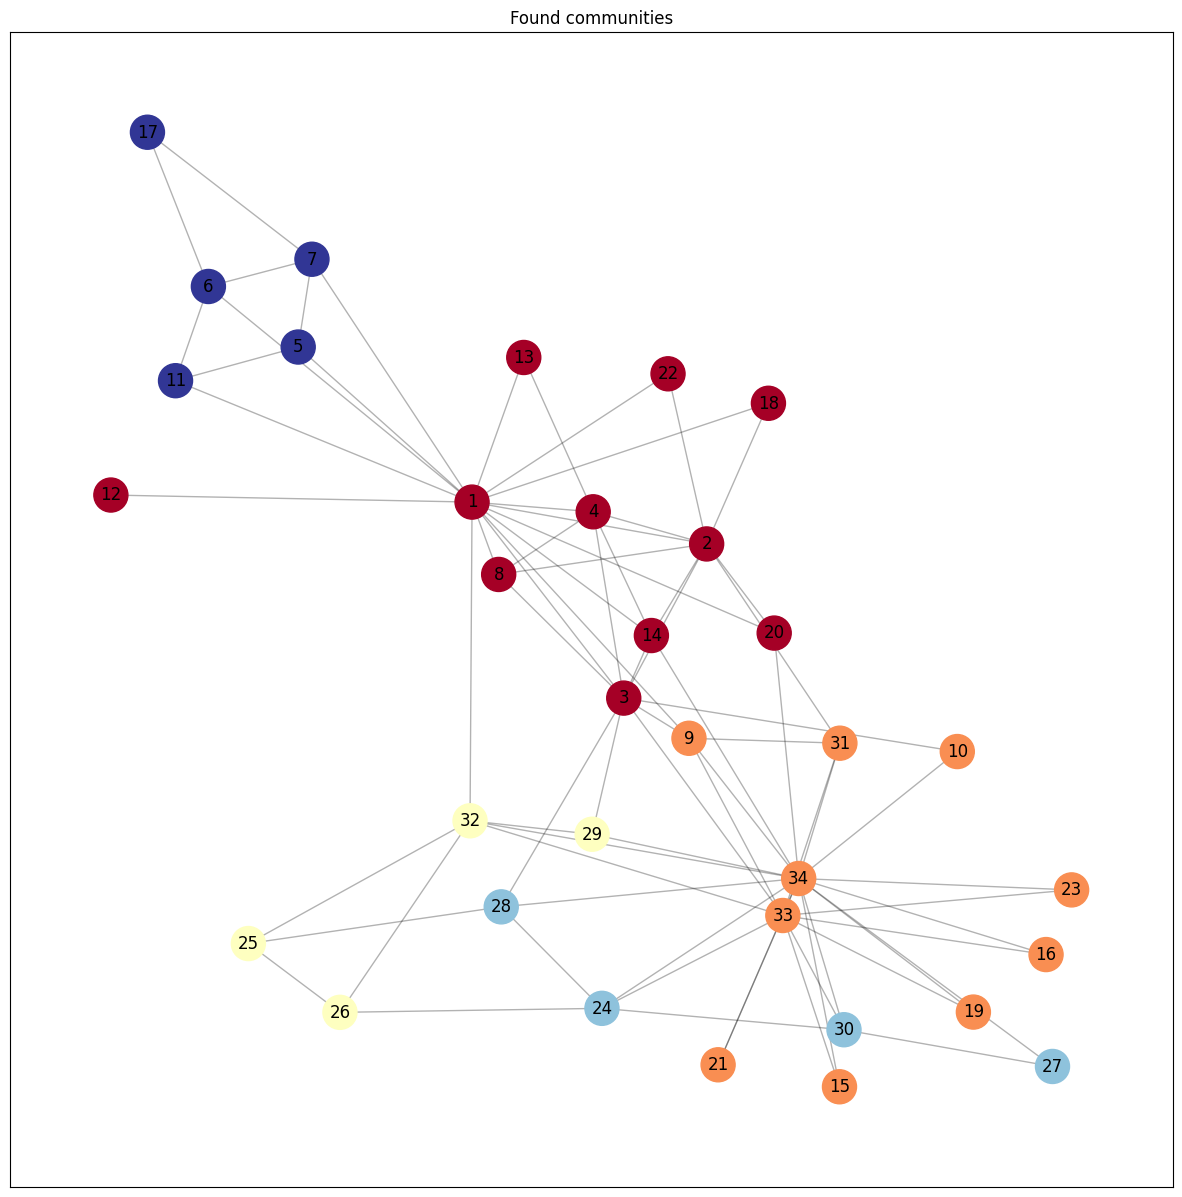

In [4]:
GA("communityDetection/data/karate/karate.gml")

Generation 0: Best Fitness = -0.0006016011846915624
Generation 250: Best Fitness = 0.282770553421671
Generation 500: Best Fitness = 0.3800474082301099
Best community structure:
Community 0: [8, 10, 12, 15, 23, 27, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 54, 55]
Community 1: [0, 1, 2, 4, 5, 6, 18, 29]
Community 2: [13, 20, 48, 49, 57]
Community 3: [91]
Community 4: [87, 98]
Community 5: [24, 26, 53]
Community 6: [9, 45, 47, 50, 52]
Community 7: [7, 85]
Community 8: [59, 61]
Community 9: [67, 103, 104]
Community 10: [21]
Community 11: [30, 60, 62, 63, 66, 73, 79, 80, 81, 83, 84, 86, 90, 93, 94, 95, 96, 97, 99, 100, 101, 102]
Community 12: [51, 58, 64, 65, 68, 69]
Community 13: [19, 31, 56, 70, 71, 74, 75, 76, 77, 78, 82]
Community 14: [3, 11, 14, 16, 17, 22, 25]
Community 15: [28, 72, 88, 89, 92]


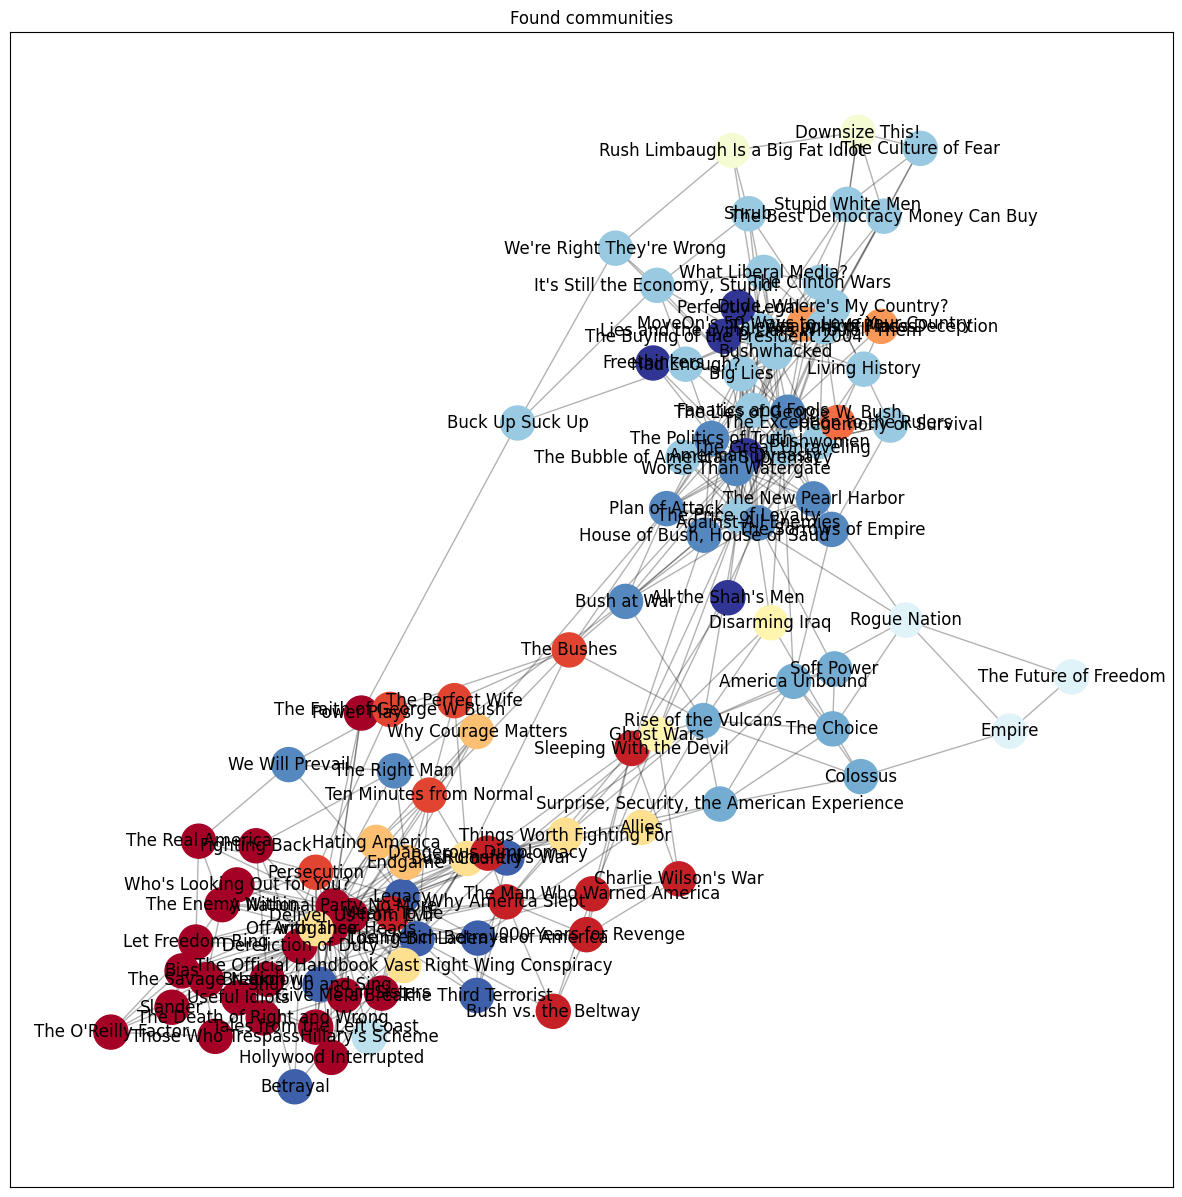

In [5]:
GA("communityDetection/data/krebs/krebs.gml")

Generation 0: Best Fitness = -0.0005042311640056774
Best community structure:
Community 0: [2872]
Community 1: [3742]
Community 2: [1637]
Community 3: [2313, 3019]
Community 4: [1263, 2977]
Community 5: [3635]
Community 6: [1896, 3276]
Community 7: [981, 1600, 3669]
Community 8: [1349, 3433]
Community 9: [3374, 3795]
Community 10: [99, 1234, 1473, 4027]
Community 11: [1675, 3296]
Community 12: [2535]
Community 13: [2092, 3836]
Community 14: [2424]
Community 15: [1122, 1963]
Community 16: [334, 2855, 3499]
Community 17: [796, 1193]
Community 18: [306, 1202, 1528, 1571]
Community 19: [1894]
Community 20: [1179, 1557, 2158]
Community 21: [376, 412]
Community 22: [354]
Community 23: [208, 1760]
Community 24: [638, 3166]
Community 25: [1028]
Community 26: [1861]
Community 27: [2841]
Community 28: [1524, 1864]
Community 29: [806, 838, 3811]
Community 30: [1072, 1560, 3507]
Community 31: [547, 2380]
Community 32: [226, 1536, 3242]
Community 33: [935, 1043]
Community 34: [196]
Community 35: [2

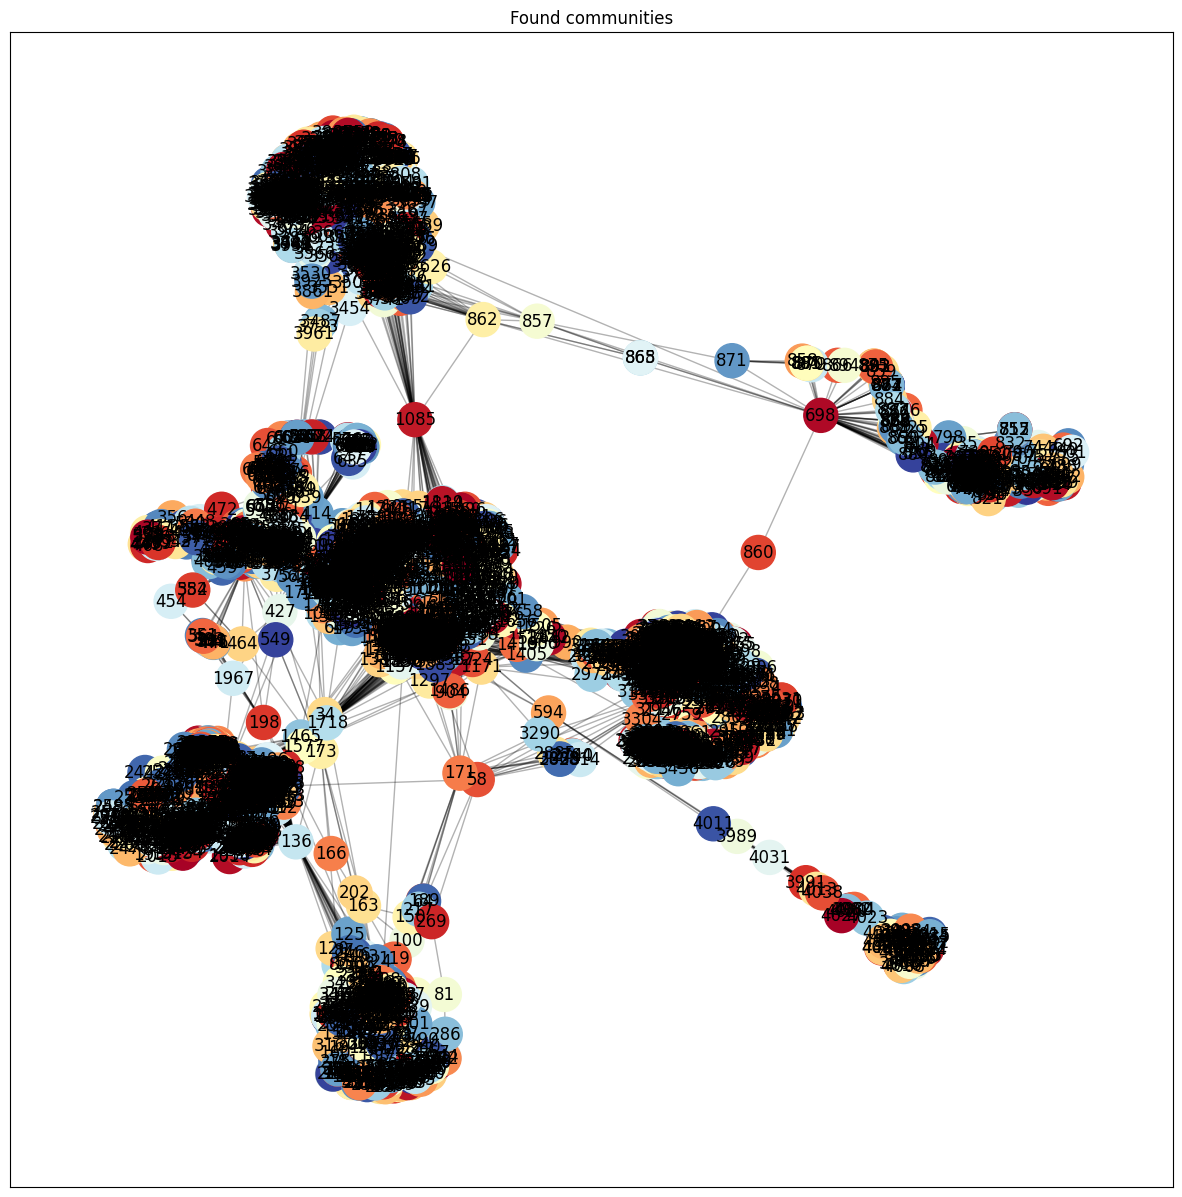

In [6]:
GA("communityDetection/data/facebook.gml", 30, 50)

In [7]:
GA("communityDetection/data/facebook.gml")

Generation 0: Best Fitness = -0.0004811871693867934
